In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib_fontja
import separator

In [21]:
url = input("Enter the YouTube video URL: ")
file = separator.download_and_separate_audio(url)

[youtube] Extracting URL: https://youtu.be/pdkXf2Ztunk?si=PVFaWXtxMQ1_L_RR
[youtube] pdkXf2Ztunk: Downloading webpage
[youtube] pdkXf2Ztunk: Downloading tv client config
[youtube] pdkXf2Ztunk: Downloading tv player API JSON
[youtube] pdkXf2Ztunk: Downloading ios player API JSON
[youtube] pdkXf2Ztunk: Downloading m3u8 information
[info] pdkXf2Ztunk: Downloading 1 format(s): 251
[download] Destination: downloaded_audio\download.webm
[download] 100% of    2.73MiB in 00:00:00 at 39.52MiB/s  
[ExtractAudio] Destination: downloaded_audio\download.wav
Deleting original file downloaded_audio\download.webm (pass -k to keep)
[Metadata] Adding metadata to "downloaded_audio\download.wav"
[youtube] Extracting URL: https://youtu.be/pdkXf2Ztunk?si=PVFaWXtxMQ1_L_RR
[youtube] pdkXf2Ztunk: Downloading webpage
[youtube] pdkXf2Ztunk: Downloading tv client config
[youtube] pdkXf2Ztunk: Downloading tv player API JSON
[youtube] pdkXf2Ztunk: Downloading ios player API JSON
[youtube] pdkXf2Ztunk: Downloading m

2025-06-29 03:11:15,883 - INFO - separator - Separator version 0.34.1 instantiating with output_dir: ./separated_audio, output_format: WAV
2025-06-29 03:11:15,883 - INFO - separator - Using model directory from model_file_dir parameter: /tmp/audio-separator-models/
2025-06-29 03:11:15,884 - INFO - separator - Operating System: Windows 10.0.22631
2025-06-29 03:11:15,884 - INFO - separator - System: Windows Node: Yuzuki_PC Release: 11 Machine: AMD64 Proc: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
2025-06-29 03:11:15,885 - INFO - separator - Python Version: 3.13.5
2025-06-29 03:11:15,885 - INFO - separator - PyTorch Version: 2.7.1+cu128
2025-06-29 03:11:15,913 - INFO - separator - FFmpeg installed: ffmpeg version 7.1.1-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
2025-06-29 03:11:15,916 - INFO - separator - ONNX Runtime GPU package installed with version: 1.22.0
2025-06-29 03:11:15,918 - INFO - separator - CUDA is available in Torch, setting Torch device

Downloaded audio for: ずうっといっしょ！ / キタニタツヤ - ALWAYS BE WITH YOU XD / Tatsuya Kitani
ずうっといっしょ！___キタニタツヤ_-_ALWAYS_BE_WITH_YOU_XD___Tatsuya_Kitani


2025-06-29 03:11:18,004 - INFO - mdxc_separator - MDXC Separator initialisation complete
2025-06-29 03:11:18,005 - INFO - separator - Load model duration: 00:00:02
2025-06-29 03:11:18,005 - INFO - separator - Processing file: ./downloaded_audio/download.wav
2025-06-29 03:11:18,006 - INFO - separator - Starting separation process for audio_file_path: ./downloaded_audio/download.wav
100%|██████████| 23/23 [00:19<00:00,  1.16it/s]
2025-06-29 03:11:38,567 - INFO - mdxc_separator - Saving other stem to Inst.wav...
2025-06-29 03:11:38,613 - INFO - common_separator - Audio duration is 0.05 hours (181.01 seconds).
2025-06-29 03:11:38,614 - INFO - common_separator - Using pydub for writing.
2025-06-29 03:11:38,870 - INFO - mdxc_separator - Saving vocals stem to Vocals.wav...
2025-06-29 03:11:38,913 - INFO - common_separator - Audio duration is 0.05 hours (181.01 seconds).
2025-06-29 03:11:38,914 - INFO - common_separator - Using pydub for writing.
2025-06-29 03:11:39,648 - INFO - common_separat

In [22]:
file = './separated_audio/vocals.wav'
audio, sr = librosa.load(file)

In [ ]:
top_db = 30

fmin=librosa.note_to_hz('C1')
fmax=librosa.note_to_hz('C7')
frame_length = 2048
hop_length = frame_length // 4

intervals = librosa.effects.split(audio, top_db=top_db, frame_length=frame_length, hop_length=hop_length)

print(f"元の音声長: {librosa.get_duration(y=audio, sr=sr):.2f} 秒")
print(f"検出された有効な音声区間の数: {len(intervals)}")
for i, (start, end) in enumerate(intervals):
    print(f"  区間 {i}: {start/sr:.2f} 秒から {end/sr:.2f} 秒まで")

# --- 3. 各区間でピッチを推定し、結果を結合 ---
all_f0 = []
all_voiced_flags = []
all_voiced_probs = []

print("\n各区間でPYINを実行中...")

for start_i, end_i in intervals:
    # 区間ごとの音声データを切り出す
    y_interval = audio[start_i:end_i]
    
    # 区間ごとにPYINを実行
    f0, voiced_flag, voiced_prob = librosa.pyin(
        y_interval,
        fmin=fmin,
        fmax=fmax,
        sr=sr,
        frame_length=frame_length,
        hop_length=hop_length
    )
    
    # 結果をリストに追加
    all_f0.append(f0)
    all_voiced_flags.append(voiced_flag)
    all_voiced_probs.append(voiced_prob)
    print(f"  区間 {start_i/sr:.2f} 秒から {end_i/sr:.2f} 秒までのピッチ推定完了。")
    print("進捗: {:.2f}%".format((start_i / len(audio)) * 100))

# 全区間の結果を一つのNumpy配列に結合
if all_f0:
    f0_combined = np.concatenate(all_f0)
    voiced_flag_combined = np.concatenate(all_voiced_flags)
    voiced_prob_combined = np.concatenate(all_voiced_probs)
else:
    # 有効な区間が一つもなかった場合
    f0_combined, voiced_flag_combined, voiced_prob_combined = [], [], []

print("PYINの実行完了。")

元の音声長: 181.01 秒
検出された有効な音声区間の数: 17
  区間 0: 3.25 秒から 3.34 秒まで
  区間 1: 15.98 秒から 16.07 秒まで
  区間 2: 20.78 秒から 36.34 秒まで
  区間 3: 38.71 秒から 41.73 秒まで
  区間 4: 41.77 秒から 41.87 秒まで
  区間 5: 42.07 秒から 47.16 秒まで
  区間 6: 47.23 秒から 70.05 秒まで
  区間 7: 70.77 秒から 85.91 秒まで
  区間 8: 99.10 秒から 100.54 秒まで
  区間 9: 100.57 秒から 126.87 秒まで
  区間 10: 127.59 秒から 131.17 秒まで
  区間 11: 131.19 秒から 133.14 秒まで
  区間 12: 133.21 秒から 159.24 秒まで
  区間 13: 159.29 秒から 159.47 秒まで
  区間 14: 166.39 秒から 169.99 秒まで
  区間 15: 170.04 秒から 170.32 秒まで
  区間 16: 170.67 秒から 170.90 秒まで

各区間でPYINを実行中...
  区間 3.25 秒から 3.34 秒までのピッチ推定完了。
進捗: 1.80%
  区間 15.98 秒から 16.07 秒までのピッチ推定完了。
進捗: 8.83%
  区間 20.78 秒から 36.34 秒までのピッチ推定完了。
進捗: 11.48%
  区間 38.71 秒から 41.73 秒までのピッチ推定完了。
進捗: 21.38%
  区間 41.77 秒から 41.87 秒までのピッチ推定完了。
進捗: 23.08%
  区間 42.07 秒から 47.16 秒までのピッチ推定完了。
進捗: 23.24%
  区間 47.23 秒から 70.05 秒までのピッチ推定完了。
進捗: 26.09%
  区間 70.77 秒から 85.91 秒までのピッチ推定完了。
進捗: 39.10%
  区間 99.10 秒から 100.54 秒までのピッチ推定完了。
進捗: 54.75%
  区間 100.57 秒から 126.87 秒までのピッチ推定完了。
進捗: 55.56%
 

In [19]:
import math

def my_round_int(number):
    return int((number * 2 + 1) // 2)

def hz_to_midi(hz):
    midi = 12 * (math.log2(hz / 440)) + 69
    midi = my_round_int(midi)
    return midi

In [11]:
def midi_to_simplified_note_name(midi_number):
    if not 0 <= midi_number <= 127:
        return "N/A"

    note_names_base = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    note_index = int(midi_number % 12)
    base_note = note_names_base[note_index]
    print(note_index)

    if midi_number <= 20:
        return "lowlowlow" + base_note
    elif midi_number <= 32:
        return "lowlow" + base_note
    elif midi_number <= 44:
        return "low" + base_note
    elif midi_number <= 56:
        return "mid1" + base_note
    elif midi_number <= 68:
        return "mid2" + base_note
    elif midi_number <= 80:
        return "hi" + base_note
    elif midi_number <= 92:
        return "hihi" + base_note
    elif midi_number <= 104:
        return "hihihi" + base_note
    else:
        return "hihihihi" + base_note

In [12]:
import numpy as np
def z_score_remove_outliers(data):
    valid_indices = ~np.isnan(data)
    temp_f0 = data[valid_indices]
    print(temp_f0)
    # zスコア法を使用して外れ値を検出
    mean = np.mean(temp_f0)
    print(mean)
    std_dev = np.std(temp_f0)
    print(std_dev)
    
    temp_f0 = temp_f0[(temp_f0 >= mean - 2 * std_dev) & (temp_f0 <= mean + 2 * std_dev)]
    z_scores = (temp_f0 - mean) / std_dev
    print(z_scores)

    outliers = temp_f0[np.abs(z_scores) > 2]
    # nanを除外したデータを返す
    print(f"Removed {len(outliers)} outliers from the data.")
    print(temp_f0)
    return temp_f0

[752.9236226  752.9236226  752.9236226  ... 450.28451248 452.89298412
 455.51656649]
217.38743355491107
89.92648322239734
[-0.71721285 -0.77512715 -0.85832073 ... -1.19416917 -1.19416917
 -1.19416917]
Removed 0 outliers from the data.
[152.89100418 147.68297531 140.20166901 ... 110.         110.
 110.        ]
Max Frequency: 383.04224785029453 Hz, Min Frequency: 82.88426748110166 Hz
7
4
Max MIDI: 67, Min MIDI: 40
Max Note: mid2G, Min Note: lowE


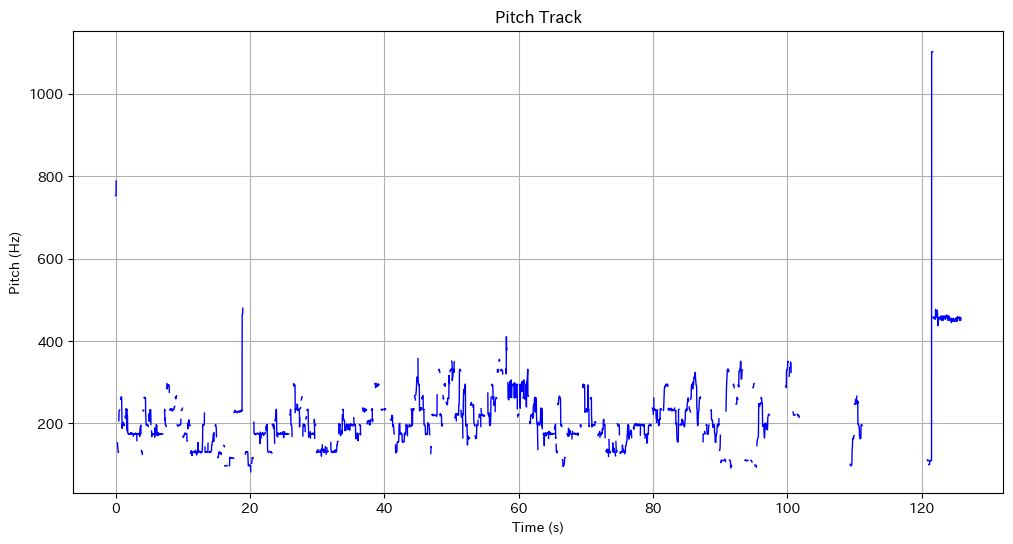

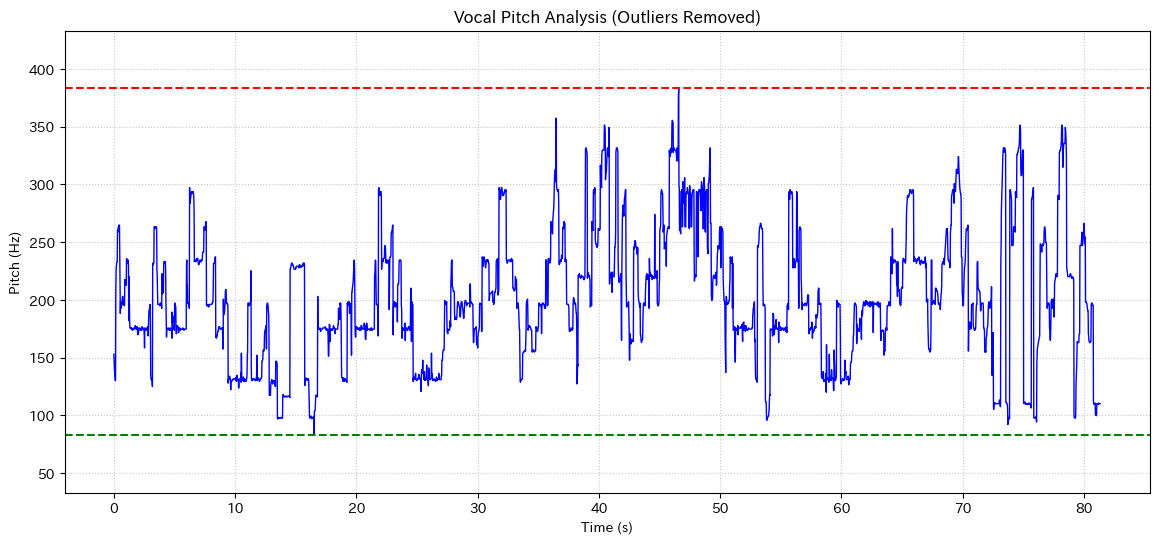

In [28]:
times = librosa.times_like(f0_combined, sr=sr)
plt.figure(figsize=(12, 6))
plt.plot(times, f0_combined, label='Pitch (Hz)', color='blue', linewidth=1)
plt.title('Pitch Track')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.grid()
plt.plot()

F0_cleaned = z_score_remove_outliers(f0_combined)

max_hz = np.max(F0_cleaned)
min_hz = np.min(F0_cleaned)
print(f"Max Frequency: {max_hz} Hz, Min Frequency: {min_hz} Hz")
max_midi = hz_to_midi(max_hz)
min_midi = hz_to_midi(min_hz)
max_note = midi_to_simplified_note_name(max_midi)
min_note = midi_to_simplified_note_name(min_midi)


print(f"Max MIDI: {max_midi}, Min MIDI: {min_midi}")
print(f"Max Note: {max_note}, Min Note: {min_note}")

F0_times = librosa.times_like(F0_cleaned, sr=sr)

plt.figure(figsize=(14, 6))
plt.plot(F0_times, F0_cleaned, label='Pitch (Hz) - Cleaned', color='blue', linewidth=1)
plt.axhline(y=max_hz, color='red', linestyle='--', label=f'MID Max Pitch: {max_note} ({max_hz:.2f} Hz)')
plt.axhline(y=min_hz, color='green', linestyle='--', label=f'MID Min Pitch: {min_note} ({min_hz:.2f} Hz)')
plt.ylim([min_hz - 50, max_hz + 50])
plt.title('Vocal Pitch Analysis (Outliers Removed)')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()